In [2]:
import numpy as np
import pandas as pd
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ReviewData = pd.read_excel('/content/drive/MyDrive/NLP/Summer Project/Benchmark construction/Data/Apple App Store Review data collection.xlsx')
AppData = pd.read_excel('/content/drive/MyDrive/NLP/Summer Project/Benchmark construction/Data/App Data.xlsx')
ReviewData.head()


,App_id,Review_user,Review_title,Review_context,Review_date,Review_star
0,1,KimP055IBLE,Reluctant… but honest,"As soon as I give something props, I usually r...",08/27/2021,5
1,1,ogleefli,Review,This app is amazing! It is a great way to cure...,07/29/2021,4
2,1,Rachelnicole97,Great app but beware,I got Tiktok during the pandemic last year. I ...,07/27/2021,3
3,1,DreamNyuro,"AMAZING, just a few suggestions","I’ve been on Tik Tok since 2018, and have been...",08/27/2021,4
4,1,breannalll,Some complaints and suggestions,"I like this app, but there's a couple of thing...",05/28/2021,3


In [ ]:
AppData.head()

,App_id,App_name,App_Company,App_Type,Overall_Rating,Overall_Rating_Number_k,Latest_version,Review_link
0,1,TikTok,TikTok Pte. Ltd.,Entertainment,4.7,10360,2021-09-09,https://apps.apple.com/us/app/tiktok/id8355993...
1,2,"YouTube: Watch, Listen, Stream",Google LLC,Photo & Video,4.7,22260,2021-09-12,https://apps.apple.com/us/app/youtube-watch-li...
2,3,Instagram,"Instagram, Inc.",Photo & Video,4.7,21620,2021-09-13,https://apps.apple.com/us/app/instagram/id3898...
3,4,Snapchat,"Snap, Inc.",Photo & Video,3.6,890,2021-09-13,https://apps.apple.com/us/app/snapchat/id44718...
4,5,Twitter,"Twitter, Inc.",News,4.6,5140,2021-09-08,https://apps.apple.com/us/app/twitter/id333903...


In [ ]:
ReviewData = ReviewData.dropna()
ReviewData.head()

,App_id,Review_user,Review_title,Review_context,Review_date,Review_star
0,1,KimP055IBLE,Reluctant… but honest,"As soon as I give something props, I usually r...",08/27/2021,5
1,1,ogleefli,Review,This app is amazing! It is a great way to cure...,07/29/2021,4
2,1,Rachelnicole97,Great app but beware,I got Tiktok during the pandemic last year. I ...,07/27/2021,3
3,1,DreamNyuro,"AMAZING, just a few suggestions","I’ve been on Tik Tok since 2018, and have been...",08/27/2021,4
4,1,breannalll,Some complaints and suggestions,"I like this app, but there's a couple of thing...",05/28/2021,3


In [ ]:
ReviewData['Review_star'].value_counts()

5    22084
1    11951
4     9665
3     8431
2     5605
Name: Review_star, dtype: int64

# Sentiment polarity calculation for app reviews

In [ ]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 636 kB 50.7 MB/s 
     |████████████████████████████████| 895 kB 37.5 MB/s 
     |████████████████████████████████| 3.3 MB 36.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from transformers import BertForSequenceClassification

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = 3,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/Summer Project/sentiment analysis/Bert_weights_sentiment_analysis.pth'))
model = model.to('cuda') 
device = 'cuda'

batchsize = 256
batchnum = int(len(Data)/batchsize)+1

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
p_results0, p_results1, p_results2 = [], [], []
prediction_results = []
for i in range(batchnum):
    if i==(batchnum-1):
        n = len(Data)%batchsize
    else:
        n = batchsize
        
    encoded_data_pred = tokenizer.batch_encode_plus(
        Data['text'][(i*batchsize):(i*batchsize+n)].values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_pred = encoded_data_pred['input_ids']
    attention_masks_pred = encoded_data_pred['attention_mask']
    
    batch = tuple(b.to(device) for b in encoded_data_pred.values())
    inputs = {
            'input_ids': batch[0],
            'token_type_ids': batch[1],
            'attention_mask': batch[2],
            }

    with torch.no_grad():        
        outputs = model(**inputs)

    logits = outputs[0]
    softmax = torch.nn.Softmax(dim=1)
    p_result = softmax(logits).detach().cpu().numpy()
    p_results0 = p_results0 + list(p_result[:,0])
    p_results1 = p_results1 + list(p_result[:,1])
    p_results2 = p_results2 + list(p_result[:,2])

    prediction_result = [np.argmax(c) for c in p_result]
    prediction_results = prediction_results + prediction_result
    

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# sentiment score0: Negative
# sentiment score1: Neutral
# sentiment score2: Positive

Data["sentiment score0"] = p_results0
Data["sentiment score1"] = p_results1
Data["sentiment score2"] = p_results2
Data["sentiment prediction"] = prediction_results

In [ ]:
Data.head()

,App_id,Review_user,Review_title,Review_context,Review_date,Review_star,text,sentiment score0,sentiment score1,sentiment score2,sentiment prediction
index,,,,,,,,,,,
0,1,KimP055IBLE,Reluctant… but honest,"As soon as I give something props, I usually r...",08/27/2021,5,Reluctant… but honestAs soon as I give somethi...,0.009426,0.000442,0.990131,2
1,1,ogleefli,Review,This app is amazing! It is a great way to cure...,07/29/2021,4,ReviewThis app is amazing! It is a great way t...,0.617391,0.000816,0.381793,0
2,1,Rachelnicole97,Great app but beware,I got Tiktok during the pandemic last year. I ...,07/27/2021,3,Great app but bewareI got Tiktok during the pa...,0.963040,0.000087,0.036874,0
3,1,DreamNyuro,"AMAZING, just a few suggestions","I’ve been on Tik Tok since 2018, and have been...",08/27/2021,4,"AMAZING, just a few suggestionsI’ve been on Ti...",0.001488,0.000052,0.998461,2
4,1,breannalll,Some complaints and suggestions,"I like this app, but there's a couple of thing...",05/28/2021,3,Some complaints and suggestionsI like this app...,0.982875,0.000112,0.017013,0


In [ ]:
Data.to_excel('/content/drive/MyDrive/NLP/Summer Project/Benchmark construction/Review_Data_with_sentiment_polarity.xlsx')

# Sarcasm Detection for app reviews

In [3]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [4]:
Data = pd.read_excel('/content/drive/MyDrive/NLP/Summer Project/Benchmark construction/Review_Data_with_sentiment_polarity.xlsx')
AppData = pd.read_excel('/content/drive/MyDrive/NLP/Summer Project/Benchmark construction/Data/App Data.xlsx')

In [5]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 36.2 MB/s 
     |████████████████████████████████| 895 kB 39.7 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 636 kB 37.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import torch
from transformers import BertForSequenceClassification

In [7]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = 2,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/Summer Project/sarcasm detection/Bert_Weights_Sarcasm_Detection.pth'))
model = model.to('cuda') 
device = 'cuda'

batchsize = 256
batchnum = int(len(Data)/batchsize)+1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
p_results0, p_results1 = [], []
prediction_results = []
for i in range(batchnum):
    if i==(batchnum-1):
        n = len(Data)%batchsize
    else:
        n = batchsize
        
    encoded_data_pred = tokenizer.batch_encode_plus(
        Data['text'][(i*batchsize):(i*batchsize+n)].values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_pred = encoded_data_pred['input_ids']
    attention_masks_pred = encoded_data_pred['attention_mask']
    
    batch = tuple(b.to(device) for b in encoded_data_pred.values())
    inputs = {
            'input_ids': batch[0],
            'token_type_ids': batch[1],
            'attention_mask': batch[2],
            }

    with torch.no_grad():        
        outputs = model(**inputs)

    logits = outputs[0]
    softmax = torch.nn.Softmax(dim=1)
    p_result = softmax(logits).detach().cpu().numpy()
    p_results0 = p_results0 + list(p_result[:,0])
    p_results1 = p_results1 + list(p_result[:,1])

    prediction_result = [np.argmax(c) for c in p_result]
    prediction_results = prediction_results + prediction_result
    

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
# sarcasm score0: no sarcasm
# sarcasm score1: sarcasm

Data["sarcasm score0"] = p_results0
Data["sarcasm score1"] = p_results1
Data["sarcasm prediction"] = prediction_results

In [14]:
Data.head()

,index,App_id,Review_user,Review_title,Review_context,Review_date,Review_star,text,sentiment score0,sentiment score1,sentiment score2,sentiment prediction,sarcasm score0,sarcasm score1,sarcasm prediction
0,0,1,KimP055IBLE,Reluctant… but honest,"As soon as I give something props, I usually r...",08/27/2021,5,Reluctant… but honestAs soon as I give somethi...,0.009426,0.000442,0.990131,2,0.000295,0.999705,1
1,1,1,ogleefli,Review,This app is amazing! It is a great way to cure...,07/29/2021,4,ReviewThis app is amazing! It is a great way t...,0.617391,0.000816,0.381793,0,0.000112,0.999888,1
2,2,1,Rachelnicole97,Great app but beware,I got Tiktok during the pandemic last year. I ...,07/27/2021,3,Great app but bewareI got Tiktok during the pa...,0.963040,0.000087,0.036874,0,0.000050,0.999950,1
3,3,1,DreamNyuro,"AMAZING, just a few suggestions","I’ve been on Tik Tok since 2018, and have been...",08/27/2021,4,"AMAZING, just a few suggestionsI’ve been on Ti...",0.001488,0.000052,0.998461,2,0.123723,0.876277,1
4,4,1,breannalll,Some complaints and suggestions,"I like this app, but there's a couple of thing...",05/28/2021,3,Some complaints and suggestionsI like this app...,0.982875,0.000112,0.017013,0,0.000217,0.999783,1


In [15]:
Data.to_excel('/content/drive/MyDrive/NLP/Summer Project/Benchmark construction/Review_Data_with_sentiment_and_sarcasm_score.xlsx')

# Text Preprocessing

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

In [11]:
ReviewData = pd.read_excel('/content/drive/MyDrive/NLP/Summer Project/Benchmark construction/Review_Data_with_sentiment_and_sarcasm_score.xlsx')
AppData = pd.read_excel('/content/drive/MyDrive/NLP/Summer Project/Benchmark construction/Data/App Data.xlsx')

In [12]:
ReviewData = ReviewData.drop(columns=['Unnamed: 0', 'index'])
ReviewData.head()

,App_id,Review_user,Review_title,Review_context,Review_date,Review_star,text,sentiment score0,sentiment score1,sentiment score2,sentiment prediction,sarcasm score0,sarcasm score1,sarcasm prediction
0,1,KimP055IBLE,Reluctant… but honest,"As soon as I give something props, I usually r...",08/27/2021,5,Reluctant… but honestAs soon as I give somethi...,0.009426,0.000442,0.990131,2,0.000295,0.999705,1
1,1,ogleefli,Review,This app is amazing! It is a great way to cure...,07/29/2021,4,ReviewThis app is amazing! It is a great way t...,0.617391,0.000816,0.381793,0,0.000112,0.999888,1
2,1,Rachelnicole97,Great app but beware,I got Tiktok during the pandemic last year. I ...,07/27/2021,3,Great app but bewareI got Tiktok during the pa...,0.963040,0.000087,0.036874,0,0.000050,0.999950,1
3,1,DreamNyuro,"AMAZING, just a few suggestions","I’ve been on Tik Tok since 2018, and have been...",08/27/2021,4,"AMAZING, just a few suggestionsI’ve been on Ti...",0.001488,0.000052,0.998461,2,0.123723,0.876277,1
4,1,breannalll,Some complaints and suggestions,"I like this app, but there's a couple of thing...",05/28/2021,3,Some complaints and suggestionsI like this app...,0.982875,0.000112,0.017013,0,0.000217,0.999783,1


In [15]:
ReviewData.shape

(57736, 14)

In [16]:
ReviewData["index"] = range(0,len(ReviewData))
ReviewData = ReviewData.set_index("index")
ReviewData["text"] = ReviewData['Review_title'] + ReviewData['Review_context']
ReviewData.head()

,App_id,Review_user,Review_title,Review_context,Review_date,Review_star,text,sentiment score0,sentiment score1,sentiment score2,sentiment prediction,sarcasm score0,sarcasm score1,sarcasm prediction
index,,,,,,,,,,,,,,
0,1,KimP055IBLE,Reluctant… but honest,"As soon as I give something props, I usually r...",08/27/2021,5,Reluctant… but honestAs soon as I give somethi...,0.009426,0.000442,0.990131,2,0.000295,0.999705,1
1,1,ogleefli,Review,This app is amazing! It is a great way to cure...,07/29/2021,4,ReviewThis app is amazing! It is a great way t...,0.617391,0.000816,0.381793,0,0.000112,0.999888,1
2,1,Rachelnicole97,Great app but beware,I got Tiktok during the pandemic last year. I ...,07/27/2021,3,Great app but bewareI got Tiktok during the pa...,0.963040,0.000087,0.036874,0,0.000050,0.999950,1
3,1,DreamNyuro,"AMAZING, just a few suggestions","I’ve been on Tik Tok since 2018, and have been...",08/27/2021,4,"AMAZING, just a few suggestionsI’ve been on Ti...",0.001488,0.000052,0.998461,2,0.123723,0.876277,1
4,1,breannalll,Some complaints and suggestions,"I like this app, but there's a couple of thing...",05/28/2021,3,Some complaints and suggestionsI like this app...,0.982875,0.000112,0.017013,0,0.000217,0.999783,1


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
STOPWORDS = set(stopwords.words('english'))
corpus=[]
for i in range(0,len(ReviewData)):

    # Remove bad symbols
    #review = re.sub('[^a-zA-Z]', ' ',Data['text'][i])
    review = re.sub('[/(){}\[\]\|@!,;]', ' ',ReviewData['Review_title'][i])
    #review = re.sub('[^0-9a-z #+_♥️]', ' ',Data['text'][i])
    #review = re.sub('[#+_]', ' ',Data['text'][i])

    review = review.lower()
    review = review.split()
    stemmer = PorterStemmer()
    review = [stemmer.stem(token) for token in review if token not in STOPWORDS]
    review=' '.join(review)
    corpus.append(review)
corpus

In [ ]:
words = []
Sentiment_Polarity=[]
for i in range(0,len(corpus)):
    words = words + (re.findall(r'\w+', corpus[i]))# words cantain all the words in the dataset
    Sentiment_Polarity.append
words

In [24]:
from collections import Counter
words_counts = Counter(words)

In [25]:
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)
most_commmom_wordList = []
most_commmom_CountList = []
for x, y in most_common_words:
    most_commmom_wordList.append(x)
    most_commmom_CountList.append(y)

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


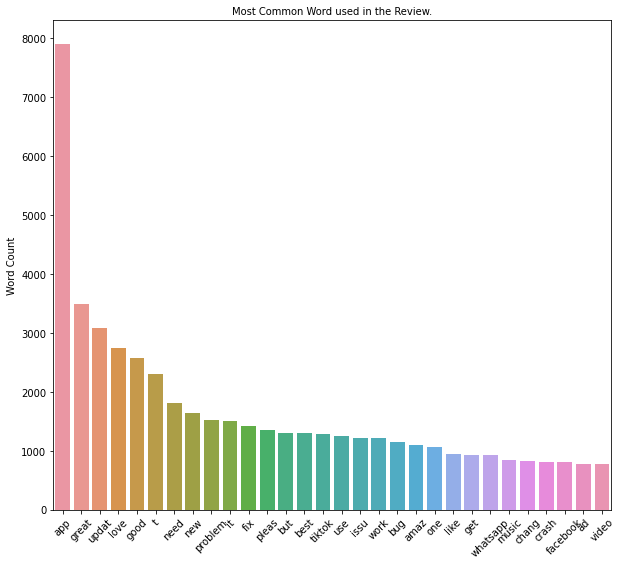

In [28]:
plt.figure(figsize=(10,9))
plot = sns.barplot(np.arange(30), most_commmom_CountList[0:30]) #width=0.35)
plt.ylabel('Word Count',fontsize=10)
plt.xticks(np.arange(30), most_commmom_wordList[0:30], fontsize=10, rotation=45)
plt.title('Most Common Word used in the Review.', fontsize=10)
plt.show()

# Benchmark construction for app reviews

In [247]:
def cos_sim(vector_a, vector_b):
    """
    calculate the cos similarity
    :param vector_a: vector a 
    :param vector_b: vector b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim


Baseline - random

In [274]:
emo_vec = [e for e in np.random.randint(1,5,len(ReviewData["Review_star"]))]
star_vec = [s for s in ReviewData["Review_star"]]
print("Cos similarity between real Review star from user and sentiment grade from model prediction:")
cos_sim_overall_random = cos_sim(star_vec, emo_vec)
print(cos_sim_overall_random)

Cos similarity between real Review star from user and sentiment grade from model prediction:
0.9148008671762917


In [285]:
print("Cos similarity in different App type:")
AppTypeList = list(np.unique(ReviewData["App_Type"]))
cos_sim_random = []
for i in range(len(AppTypeList)):
    AppType = AppTypeList[i]
    star_vec = [s for s in ReviewData["Review_star"][ReviewData["App_Type"]==AppType]]
    emo_vec = [e for e in np.random.randint(1,5,len(star_vec))]
    cos_sim_random.append(cos_sim(star_vec, emo_vec))
    print('  ', AppType, ': ', cos_sim(star_vec, emo_vec))

Cos similarity in different App type:
   Business :  0.9291684167496698
   Entertainment :  0.9249133140149601
   Music :  0.9327982171584033
   Navigation :  0.9080208327153931
   News :  0.8971731894957277
   Photo & Video :  0.9115040161163965
   Productivity :  0.9123423433995802
   Shopping :  0.9101632976985311
   Social Networking :  0.905609780099943
   Utilities :  0.9034964116215538


In [286]:
result_summary = pd.DataFrame()
AppTypeList.append("Overall")
result_summary["App Type"] = AppTypeList
cos_sim_random.append(cos_sim_overall_random)
result_summary["Baseline_Random"] = cos_sim_random
result_summary

,App Type,Baseline_Random
0,Business,0.929168
1,Entertainment,0.924913
2,Music,0.932798
3,Navigation,0.908021
4,News,0.897173
5,Photo & Video,0.911504
6,Productivity,0.912342
7,Shopping,0.910163
8,Social Networking,0.905610
9,Utilities,0.903496


Use sentiment score to predict review stars

In [287]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X = ReviewData[["sentiment score0", "sentiment score1", "sentiment score2"]]
y = ReviewData["Review_star"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [288]:
from sklearn.ensemble import RandomForestClassifier

#Create a RandomForestClassifier and train
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [289]:
ReviewData["sentiment grade"] = clf.predict(X)
ReviewData_test = ReviewData.loc[X_test.index]

In [304]:
emo_vec = [e for e in ReviewData_test["sentiment grade"]]
star_vec = [s for s in ReviewData_test["Review_star"]]
print("Cos similarity between real Review star from user and sentiment grade from model prediction:")
cos_sim_overall_sentiment = cos_sim(star_vec, emo_vec)
print(cos_sim(star_vec, emo_vec))

Cos similarity between real Review star from user and sentiment grade from model prediction:
0.9415519258167786


In [305]:
print("Cos similarity in different App type:")
cos_sim_sentiment = []
for i in range(len(AppTypeList)-1):
    AppType = AppTypeList[i]
    emo_vec = [e for e in ReviewData_test["sentiment grade"][ReviewData_test["App_Type"]==AppType]]
    star_vec = [s for s in ReviewData_test["Review_star"][ReviewData_test["App_Type"]==AppType]]
    cos_sim_sentiment.append(cos_sim(star_vec, emo_vec))
    print('  ', AppType, ': ', cos_sim(star_vec, emo_vec))

Cos similarity in different App type:
   Business :  0.964469681303656
   Entertainment :  0.9443315183138048
   Music :  0.9556541361427223
   Navigation :  0.9477907612881643
   News :  0.9082609839863427
   Photo & Video :  0.9233824822172108
   Productivity :  0.9352991412144158
   Shopping :  0.9194450598299423
   Social Networking :  0.9436506526442544
   Utilities :  0.9286490904912212


In [306]:
cos_sim_sentiment.append(cos_sim_overall_sentiment)
result_summary['Sentiment only'] = cos_sim_sentiment
result_summary

,App Type,Baseline_Random,Sentiment only
0,Business,0.929168,0.964470
1,Entertainment,0.924913,0.944332
2,Music,0.932798,0.955654
3,Navigation,0.908021,0.947791
4,News,0.897173,0.908261
5,Photo & Video,0.911504,0.923382
6,Productivity,0.912342,0.935299
7,Shopping,0.910163,0.919445
8,Social Networking,0.905610,0.943651
9,Utilities,0.903496,0.928649


Use sarcasm score to amend and improve the sentiment score

In [307]:
X = ReviewData[["sentiment score0", "sentiment score1", "sentiment score2", "sarcasm score0", "sarcasm score1"]]
y = ReviewData["Review_star"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [308]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [309]:
ReviewData["sentiment grade considering sarcasm"] = clf.predict(X)

In [310]:
ReviewData_test = ReviewData.loc[X_test.index]

In [311]:
emo_vec = [e for e in ReviewData_test["sentiment grade considering sarcasm"]]
star_vec = [s for s in ReviewData_test["Review_star"]]
print("Cos similarity between real Review star from user and sentiment grade from model prediction:")
cos_sim_overall_sarcasm = cos_sim(star_vec, emo_vec)
print(cos_sim(star_vec, emo_vec))

Cos similarity between real Review star from user and sentiment grade from model prediction:
0.944219858482225


In [312]:
print("Cos similarity in different App type:")
cos_sim_sarcasm = []
for i in range(len(AppTypeList)-1):
    AppType = AppTypeList[i]
    emo_vec = [e for e in ReviewData_test["sentiment grade considering sarcasm"][ReviewData_test["App_Type"]==AppType]]
    star_vec = [s for s in ReviewData_test["Review_star"][ReviewData_test["App_Type"]==AppType]]
    cos_sim_sarcasm.append(cos_sim(star_vec, emo_vec))
    print('  ', AppType, ': ', cos_sim(star_vec, emo_vec))

Cos similarity in different App type:
   Business :  0.9704153097267758
   Entertainment :  0.9477947321355593
   Music :  0.9548339674910414
   Navigation :  0.9487244330080854
   News :  0.9187493506327566
   Photo & Video :  0.9251041446494511
   Productivity :  0.9421151330824808
   Shopping :  0.9177415954981494
   Social Networking :  0.9460734299733748
   Utilities :  0.9344050717799499


In [313]:
cos_sim_sarcasm.append(cos_sim_overall_sarcasm)
result_summary['Sentiment with Sarcasm'] = cos_sim_sarcasm
result_summary

,App Type,Baseline_Random,Sentiment only,Sentiment with Sarcasm
0,Business,0.929168,0.964470,0.970415
1,Entertainment,0.924913,0.944332,0.947795
2,Music,0.932798,0.955654,0.954834
3,Navigation,0.908021,0.947791,0.948724
4,News,0.897173,0.908261,0.918749
5,Photo & Video,0.911504,0.923382,0.925104
6,Productivity,0.912342,0.935299,0.942115
7,Shopping,0.910163,0.919445,0.917742
8,Social Networking,0.905610,0.943651,0.946073
9,Utilities,0.903496,0.928649,0.934405


In [315]:
result_summary.to_excel("/content/drive/MyDrive/NLP/Summer Project/Result/Benchmark Accessment result.xlsx")

In [317]:
ReviewData.to_excel("/content/drive/MyDrive/NLP/Summer Project/Result/Prediction result on app store review.xlsx")